X_train shape (192, 160, 320, 3)
y_train shape (192,)
X_validation shape (96, 160, 320, 3)
y_validation shape (96,)
X_train shape (192, 160, 320, 3)
y_train shape (192,)
X_validation shape (96, 160, 320, 3)
y_validation shape (96,)
X_train shape (192, 160, 320, 3)
y_train shape (192,)
X_validation shape (96, 160, 320, 3)
y_validation shape (96,)
model created
model compiled


Epoch 1/2
1536/6429 [======>.......................] - ETA: 43s - loss: 1.5772


./data/data/IMG/center
[Errno 2] No such file or directory: './data/data/IMG/center'


./data/data/IMG/left
[Errno 2] No such file or directory: './data/data/IMG/left'


./data/data/IMG/right
[Errno 2] No such file or directory: './data/data/IMG/right'



6330/6429 [============================>.] - ETA: 0s - loss: 0.6411

C:\Users\I054267\AppData\Local\Continuum\miniconda3\envs\carnd-term1_new_tf\lib\site-packages\keras\engine\training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


6522/6429 [==============================] - 83s - loss: 0.6266 - val_loss: 0.1611
Epoch 2/2
6528/6429 [==============================] - 72s - loss: 0.1074 - val_loss: 0.0568

model trained


model saved


history_object.history.keys() = dict_keys(['loss', 'val_loss'])


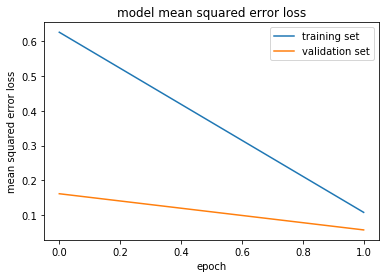

In [25]:
import csv
import cv2
from scipy import ndimage
import numpy as np
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG) #logging.INFO logging.DEBUG
if logger.handlers == []:
    ch = logging.StreamHandler()
    logger.addHandler(ch)

#--------------------------------------------------------------------------#
# Data generator
#--------------------------------------------------------------------------#
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Load training data (image file name + steering) from csv file
samples = []
with open('./data/data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

# Split 20% data as validation samples
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

# Define data generator
def generator(samples, batch_size=32, is_training=False):
    num_samples = len(samples)
    correction = 0.2
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                for i in range(3):
                    try:
                        # Load image and steering angle
                        name = './data/data/IMG/'+batch_sample[i].split('/')[-1]
                        image = ndimage.imread(name)    # Read image in BGR format
                        angle = float(batch_sample[3])
                        if i == 1:    # Left camera image steering correction
                            angle += correction 
                        elif i == 2:  # Right camera image steering correction
                            angle -= correction
                        images.append(image)
                        angles.append(angle)
                        
                        # Data augmentation by flipping if in training mode
                        if is_training:
                            images.append(cv2.flip(image, 1))
                            angles.append(angle * -1.0)
                    except Exception as e:
                        logger.debug("")
                        logger.debug(name)
                        logger.debug(str(e))
                        logger.debug("")

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32, is_training=True)
validation_generator = generator(validation_samples, batch_size=32)

# Test generator
for i in range(3):
    X_train, y_train = (next(train_generator))
    logger.debug('X_train shape {}'.format(np.shape(X_train)))
    logger.debug('y_train shape {}'.format(np.shape(y_train)))
    X_validation, y_validation = (next(validation_generator))
    logger.debug('X_validation shape {}'.format(np.shape(X_validation)))
    logger.debug('y_validation shape {}'.format(np.shape(y_validation)))

#--------------------------------------------------------------------------#
# Create train and save model
#--------------------------------------------------------------------------#
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D
import matplotlib.pyplot as plt

# Create a simple model
model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70, 25), (0,0))))
model.add(Flatten())
model.add(Dense(1))
logger.info('model created')

# Since steering will be the only output, this becomes a regression problem,
# therefore here mse(mean_squared_error) loss function is chosen
model.compile(loss='mse', optimizer='adam')
logger.info('model compiled')

# Use generate to train and evaluate model
history_object = model.fit_generator(train_generator, samples_per_epoch=len(train_samples)*6,
                                     validation_data=validation_generator,
                                     nb_val_samples=len(validation_samples), nb_epoch=2, verbose=1)
logger.info('model trained')

# Save the trained model
model.save('model.h5')
logger.info('model saved')

# Visualize training loss and validation loss
print('history_object.history.keys() = {}'.format(history_object.history.keys()))

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()